In [58]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from skimage.transform import resize
from skimage.transform import rescale
from keras.layers.core import Activation
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.layers import ELU, PReLU, LeakyReLU
from keras.layers import add
from keras.layers import Dense
from keras.layers.core import Flatten
from keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.models import load_model
import os 
import sys
import fiftyone.zoo as foz
import fiftyone as fo
from tqdm import tqdm
import cv2

inspiré librement du GitHub suivant : https://github.com/deepak112/Keras-SRGAN

In [23]:
PATH = '/home/jovyan/my_work/'

## Image Preprocessing

In [24]:
### Image preprocessing
# Takes list of images and provide HR images in form of numpy array
def hr_images(images):
    images_hr = np.array(images)
    ##we normalize the images
    images_hr_norm = (images_hr - 127.5)/127.5 
    print('here_hr')
    return images_hr_norm

def downscale_image(image, n):
    return rescale(image, 1/n, anti_aliasing=True, multichannel=True)

# Takes list of images and provide LR images in form of numpy array
def lr_images(images_real , downscale):
    """
    Process a dataset of images and return a new array with low-resolution images.
    
    Parameters:
    X_train (numpy array): The dataset of images as a numpy array.
    n (int): The downscaling factor.
    
    Returns:
    numpy array: The dataset with low-resolution images as a numpy array.
    """
    X_train_lowresolution = []
    for image in X_train:
        low_res_image = downscale_image(image, downscale)
        X_train_lowresolution.append(low_res_image)
    return X_train_lowresolution


# Subpixel Conv will upsample from (h, w, c) to (h/r, w/r, c/r^2)
def SubpixelConv2D(input_shape, scale=4):
    def subpixel_shape(input_shape):
        dims = [input_shape[0],input_shape[1] * scale,input_shape[2] * scale,int(input_shape[3] / (scale ** 2))]
        output_shape = tuple(dims)
        return output_shape
    
    def subpixel(x):
        return tf.nn.depth_to_space(x, scale)
    return Lambda(subpixel, output_shape=subpixel_shape)

def normalize(input_data):
    return (input_data.astype(np.float32) - 127.5)/127.5 
    
def denormalize(input_data):
    input_data = (input_data + 1) * 127.5
    return input_data.astype(np.uint8)

## Dataset (COCO)

In [13]:
# To download the COCO dataset for only the "person" and "car" classes
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["detections", "segmentations"],
    classes=["person", "dog"],
    max_samples=2000,
    dataset_dir = PATH + '/train/'
)

Found annotations at '/home/jovyan/my_work/train/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train-2000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [15]:
# Visualize the dataset in the FiftyOne App
#import fiftyone as fo
#session = fo.launch_app(dataset)

In [16]:
# To download the COCO dataset for only the "person" and "car" classes
validation_data= foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections", "segmentations"],
    classes=["person", "dog"],
    max_samples=100,
    dataset_dir = PATH + '/validation/'
)

 100% |██████|    1.9Gb/1.9Gb [39.4s elapsed, 0s remaining, 117.3Mb/s]      
Extracting annotations to '/home/jovyan/my_work/validation/raw/instances_val2017.json'
 100% |██████████████████| 100/100 [1.4s elapsed, 0s remaining, 97.4 images/s]         
Writing annotations for 100 downloaded samples to '/home/jovyan/my_work//validation/validation/labels.json'
Dataset info written to '/home/jovyan/my_work//validation/info.json'
Loading 'coco-2017' split 'validation'
 100% |█████████████████| 100/100 [2.0s elapsed, 0s remaining, 52.5 samples/s]         
Dataset 'coco-2017-validation-100' created


In [18]:
test_data= foz.load_zoo_dataset(
    "coco-2017",
    split="test",
    label_types=["detections", "segmentations"],
    classes=["person", "dog"],
    max_samples=300,
    dataset_dir = PATH + '/test/'
)

Test split is unlabeled; ignoring classes requirement
 100% |██████|    8.7Mb/8.7Mb [506.9ms elapsed, 0s remaining, 17.2Mb/s]      
Extracting test info to '/home/jovyan/my_work/test/raw/image_info_test2017.json'
 100% |██████████████████| 300/300 [3.2s elapsed, 0s remaining, 107.5 images/s]      
Writing annotations for 300 downloaded samples to '/home/jovyan/my_work//test/test/labels.json'
Dataset info written to '/home/jovyan/my_work//test/info.json'
Loading 'coco-2017' split 'test'
Dataset is unlabeled; ignoring classes requirement
 100% |█████████████████| 300/300 [131.1ms elapsed, 0s remaining, 2.4K samples/s]  
Dataset 'coco-2017-test-300' created


In [19]:
dataset

Name:        coco-2017-train-2000
Media type:  None
Num samples: 0
Persistent:  False
Tags:        []
Sample fields:
    id:       fiftyone.core.fields.ObjectIdField
    filepath: fiftyone.core.fields.StringField
    tags:     fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)

In [25]:
train_data_path = PATH + '/train/train/data/'
test_data_path = PATH + '/test/test/data/'

In [26]:
# Remember to change image shape if you are having different size of images
new_shape = (384,384)

def load_images(image_folder):
    image_filenames = os.listdir(image_folder)
    images = []
    for filename in image_filenames:
        img = cv2.imread(os.path.join(image_folder, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = resize(img, new_shape, mode='reflect', anti_aliasing=True)
        ##img = img.astype(np.float32) / 255.0
        images.append(img)
    return np.array(images)

# Load images
X_train = load_images(train_data_path)
X_test = load_images(test_data_path)

In [27]:
x_train_hr = hr_images(X_train)
x_train_lr = lr_images(X_train, 4)

here_hr


In [28]:
x_test_hr = hr_images(X_test)
x_test_lr = lr_images(X_test, 4)

here_hr


In [29]:
x_train_hr[70].shape

(384, 384, 3)

## GAN Model

In [30]:
# Residual block
def res_block_gen(model, kernal_size, filters, strides):    
    gen = model
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    # Using Parametric ReLU
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = add([gen, model])
    return model
    
    
def up_sampling_block(model, kernal_size, filters, strides):
    
    # In place of Conv2D and UpSampling2D we can also use Conv2DTranspose (Both are used for Deconvolution)
    # Even we can have our own function for deconvolution (i.e one made in Utils.py)
    #model = Conv2DTranspose(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = 2)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model
  
class Generator(object):
    def __init__(self, noise_shape):
        
        self.noise_shape = noise_shape
    def generator(self):
        
        gen_input = Input(shape = self.noise_shape)
     
        model = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(gen_input)
        model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
        
        gen_model = model
        
        # Using 16 Residual Blocks
        for index in range(16):
            model = res_block_gen(model, 3, 64, 1)
     
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(model)
        model = BatchNormalization(momentum = 0.5)(model)
        model = add([gen_model, model])
     
        # Using 2 UpSampling Blocks
        for index in range(2):
            model = up_sampling_block(model, 3, 256, 1)
     
        model = Conv2D(filters = 3, kernel_size = 9, strides = 1, padding = "same")(model)
        model = Activation('tanh')(model)
    
        generator_model = Model(inputs = gen_input, outputs = model)
        return generator_model

In [31]:
def discriminator_block(model, filters, kernel_size, strides):
    
    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model
  
class Discriminator(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape
    
    def discriminator(self):
        
        dis_input = Input(shape = self.image_shape)
        
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
        model = LeakyReLU(alpha = 0.2)(model)
        
        model = discriminator_block(model, 64, 3, 2)
        model = discriminator_block(model, 128, 3, 1)
        model = discriminator_block(model, 128, 3, 2)
        model = discriminator_block(model, 256, 3, 1)
        model = discriminator_block(model, 256, 3, 2)
        model = discriminator_block(model, 512, 3, 1)
        model = discriminator_block(model, 512, 3, 2)
        
        model = Flatten()(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha = 0.2)(model)
       
        model = Dense(1)(model)
        model = Activation('sigmoid')(model) 
        
        discriminator_model = Model(inputs = dis_input, outputs = model)
        
        return discriminator_model

In [32]:
def vgg_loss(y_true, y_pred, model):
    return K.mean(K.square(model(y_true) - model(y_pred)))

def vgg_loss_wrapper(image_shape):
    vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=image_shape)
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False
    model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
    model.trainable = False

    def loss_function(y_true, y_pred):
        return vgg_loss(y_true, y_pred, model)
    
    return loss_function

In [33]:
def get_gan_network(discriminator, shape, generator, optimizer, vgg_loss):
    discriminator.trainable = False
    gan_input = Input(shape=shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=[vgg_loss, "binary_crossentropy"], loss_weights=[1., 1e-3], optimizer=optimizer)

    return gan

In [34]:
def get_optimizer():
    
    adam = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    return adam

In [35]:
# While training save generated image(in form LR, SR, HR)
# Save only one image as sample  
def plot_generated_images(output_dir, epoch, generator, x_test_hr, x_test_lr , dim=(1, 3), figsize=(15, 5)):
    
    examples = x_test_hr.shape[0]
    print(examples)
    value = np.random.randint(0, examples)
    image_batch_hr = denormalize(x_test_hr)
    image_batch_lr = x_test_lr
    gen_img = generator.predict(image_batch_lr)
    generated_image = denormalize(gen_img)
    image_batch_lr = denormalize(image_batch_lr)
    
    plt.figure(figsize=figsize)
    
    plt.subplot(dim[0], dim[1], 1)
    plt.imshow(image_batch_lr[value], interpolation='nearest')
    plt.axis('off')
        
    plt.subplot(dim[0], dim[1], 2)
    plt.imshow(generated_image[value], interpolation='nearest')
    plt.axis('off')
    
    plt.subplot(dim[0], dim[1], 3)
    plt.imshow(image_batch_hr[value], interpolation='nearest')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(output_dir + 'generated_image_%d.png' % epoch)
    
    #plt.show()
    
# Plots and save generated images(in form LR, SR, HR) from model to test the model 
# Save output for all images given for testing  
def plot_test_generated_images_for_model(output_dir, generator, x_test_hr, x_test_lr , dim=(1, 3), figsize=(15, 5)):
    
    examples = x_test_hr.shape[0]
    image_batch_hr = denormalize(x_test_hr)
    image_batch_lr = x_test_lr
    gen_img = generator.predict(image_batch_lr)
    generated_image = denormalize(gen_img)
    image_batch_lr = denormalize(image_batch_lr)
    
    for index in range(examples):
    
        plt.figure(figsize=figsize)
    
        plt.subplot(dim[0], dim[1], 1)
        plt.imshow(image_batch_lr[index], interpolation='nearest')
        plt.axis('off')
        
        plt.subplot(dim[0], dim[1], 2)
        plt.imshow(generated_image[index], interpolation='nearest')
        plt.axis('off')
    
        plt.subplot(dim[0], dim[1], 3)
        plt.imshow(image_batch_hr[index], interpolation='nearest')
        plt.axis('off')
    
        plt.tight_layout()
        plt.savefig(output_dir + 'test_generated_image_%d.png' % index)
    
        #plt.show()

# Takes LR images and save respective HR images
def plot_test_generated_images(output_dir, generator, x_test_lr, figsize=(5, 5)):
    
    examples = x_test_lr.shape[0]
    image_batch_lr = denormalize(x_test_lr)
    gen_img = generator.predict(image_batch_lr)
    generated_image = denormalize(gen_img)
    
    for index in range(examples):
    
        plt.figure(figsize=figsize)
        plt.imshow(generated_image[index], interpolation='nearest')
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(output_dir + 'high_res_result_image_%d.png' % index)
        plt.show()

In [71]:
# Better to use downscale factor as 4
downscale = 4
image_shape = (384,384,3)

def train(epochs, batch_size, output_dir, model_save_dir):
    # Loads training and test data
    batch_count = int(x_train_hr.shape[0] / batch_size)
    shape = (image_shape[0]//downscale, image_shape[1]//downscale, image_shape[2])
    
    generator = Generator(shape).generator()
    discriminator = Discriminator(image_shape).discriminator()

    optimizer = get_optimizer()
    loss_function = vgg_loss_wrapper(image_shape)
    generator.compile(loss=loss_function, optimizer=optimizer) #loss = vgg_loss
    discriminator.compile(loss="binary_crossentropy", optimizer=optimizer)
    
    gan = get_gan_network(discriminator, shape, generator, optimizer, loss_function)
    
    loss_file = open(model_save_dir + 'losses.txt' , 'w+')
    loss_file.close()

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size).astype(int)
            image_batch_hr = np.array([x_train_hr[i] for i in rand_nums])
            image_batch_lr = np.array([x_train_lr[i] for i in rand_nums])
            generated_images_sr = generator.predict(image_batch_lr)

            real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            fake_data_Y = np.random.random_sample(batch_size)*0.2
            
            discriminator.trainable = True
            
            d_loss_real = discriminator.train_on_batch(image_batch_hr, real_data_Y)
            d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
            discriminator_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
            
            rand_nums = np.random.randint(0, len(x_train_hr), size=batch_size).astype(int)
            image_batch_hr = np.array([x_train_hr[i] for i in rand_nums])
            image_batch_lr = np.array([x_train_lr[i] for i in rand_nums])

            gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(image_batch_lr, [image_batch_hr,gan_Y])
            
            
        print("discriminator_loss : %f" % discriminator_loss)
        print("gan_loss :", gan_loss)
        gan_loss = str(gan_loss)
        
        loss_file = open(model_save_dir + 'losses.txt' , 'a')
        loss_file.write('epoch%d : gan_loss = %s ; discriminator_loss = %f\n' %(e, gan_loss, discriminator_loss) )
        loss_file.close()

        if e == 1 or e % 10 == 0:
            #plot_generated_images(output_dir, e, generator, x_test_hr, x_test_lr)
            generator.save(model_save_dir + 'gen_model_2_%d.h5' % e)
            discriminator.save(model_save_dir + 'dis_model_2_%d.h5' % e)

In [72]:
train(60,16, PATH, PATH)

/opt/conda/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 1 ---------------


100%|██████████| 125/125 [03:25<00:00,  1.64s/it]
/opt/conda/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


discriminator_loss : 0.392002
gan_loss : [0.0009054297115653753, 3.868153362418525e-05, 0.8667480945587158]
--------------- Epoch 2 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 6.039697
gan_loss : [0.0021267244592309, 3.0589275411330163e-05, 2.096135139465332]
--------------- Epoch 3 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.806020
gan_loss : [0.0024424062576144934, 3.3526550396345556e-05, 2.4088797569274902]
--------------- Epoch 4 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 4.266230
gan_loss : [0.0024220915511250496, 3.736629878403619e-05, 2.3847250938415527]
--------------- Epoch 5 ---------------


100%|██████████| 125/125 [03:18<00:00,  1.58s/it]


discriminator_loss : 1.009792
gan_loss : [0.000552332610823214, 3.382009163033217e-05, 0.518512487411499]
--------------- Epoch 6 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.872594
gan_loss : [0.0011649279622361064, 2.7460499040898867e-05, 1.137467384338379]
--------------- Epoch 7 ---------------


100%|██████████| 125/125 [03:16<00:00,  1.57s/it]


discriminator_loss : 0.842507
gan_loss : [0.00041967013385146856, 4.9690966989146546e-05, 0.3699791431427002]
--------------- Epoch 8 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.508500
gan_loss : [0.0006555949221365154, 2.82730416074628e-05, 0.6273218393325806]
--------------- Epoch 9 ---------------


100%|██████████| 125/125 [03:15<00:00,  1.57s/it]


discriminator_loss : 1.354884
gan_loss : [0.0015998665476217866, 3.7514237192226574e-05, 1.562352180480957]
--------------- Epoch 10 ---------------


100%|██████████| 125/125 [03:15<00:00,  1.56s/it]


discriminator_loss : 0.967394
gan_loss : [0.00042468722676858306, 3.853866655845195e-05, 0.3861485421657562]
--------------- Epoch 11 ---------------


100%|██████████| 125/125 [03:15<00:00,  1.56s/it]


discriminator_loss : 1.418688
gan_loss : [0.00032508213189430535, 3.653318344731815e-05, 0.28854891657829285]
--------------- Epoch 12 ---------------


100%|██████████| 125/125 [03:14<00:00,  1.56s/it]


discriminator_loss : 0.330357
gan_loss : [0.0004735332913696766, 3.817024116870016e-05, 0.4353630542755127]
--------------- Epoch 13 ---------------


100%|██████████| 125/125 [03:14<00:00,  1.56s/it]


discriminator_loss : 0.442131
gan_loss : [0.0018241140060126781, 3.3347110729664564e-05, 1.7907668352127075]
--------------- Epoch 14 ---------------


100%|██████████| 125/125 [03:14<00:00,  1.56s/it]


discriminator_loss : 0.530461
gan_loss : [0.0010091857984662056, 3.0887902539689094e-05, 0.9782978892326355]
--------------- Epoch 15 ---------------


100%|██████████| 125/125 [03:15<00:00,  1.56s/it]


discriminator_loss : 1.664015
gan_loss : [0.002249400829896331, 2.5005065253935754e-05, 2.224395751953125]
--------------- Epoch 16 ---------------


100%|██████████| 125/125 [03:15<00:00,  1.56s/it]


discriminator_loss : 0.457586
gan_loss : [0.000900167622603476, 3.70589732483495e-05, 0.8631086349487305]
--------------- Epoch 17 ---------------


100%|██████████| 125/125 [03:15<00:00,  1.56s/it]


discriminator_loss : 0.588225
gan_loss : [0.0007490572752431035, 3.034930705325678e-05, 0.7187079191207886]
--------------- Epoch 18 ---------------


100%|██████████| 125/125 [03:15<00:00,  1.56s/it]


discriminator_loss : 0.341816
gan_loss : [0.0003760144463740289, 3.223720705136657e-05, 0.34377720952033997]
--------------- Epoch 19 ---------------


100%|██████████| 125/125 [03:15<00:00,  1.56s/it]


discriminator_loss : 0.385010
gan_loss : [0.00034367351327091455, 3.789017500821501e-05, 0.30578333139419556]
--------------- Epoch 20 ---------------


100%|██████████| 125/125 [03:16<00:00,  1.57s/it]


discriminator_loss : 0.379510
gan_loss : [0.0005751907592639327, 3.257756543462165e-05, 0.5426132082939148]
--------------- Epoch 21 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.434753
gan_loss : [0.0030555534176528454, 4.7241977881640196e-05, 3.0083112716674805]
--------------- Epoch 22 ---------------


100%|██████████| 125/125 [03:15<00:00,  1.56s/it]


discriminator_loss : 1.304627
gan_loss : [0.0005710296100005507, 3.916778223356232e-05, 0.5318618416786194]
--------------- Epoch 23 ---------------


100%|██████████| 125/125 [03:15<00:00,  1.56s/it]


discriminator_loss : 1.518076
gan_loss : [0.0005165233160369098, 5.036436050431803e-05, 0.466158926486969]
--------------- Epoch 24 ---------------


100%|██████████| 125/125 [03:14<00:00,  1.56s/it]


discriminator_loss : 0.367111
gan_loss : [0.0003724861308000982, 3.289848973508924e-05, 0.33958762884140015]
--------------- Epoch 25 ---------------


100%|██████████| 125/125 [03:15<00:00,  1.56s/it]


discriminator_loss : 0.330915
gan_loss : [0.00038887784467078745, 4.6627763367723674e-05, 0.3422500491142273]
--------------- Epoch 26 ---------------


100%|██████████| 125/125 [03:15<00:00,  1.57s/it]


discriminator_loss : 0.348358
gan_loss : [0.0005655362037941813, 3.273235051892698e-05, 0.5328038334846497]
--------------- Epoch 27 ---------------


100%|██████████| 125/125 [03:15<00:00,  1.56s/it]


discriminator_loss : 0.337597
gan_loss : [0.00037762895226478577, 3.8943151594139636e-05, 0.3386858105659485]
--------------- Epoch 28 ---------------


100%|██████████| 125/125 [03:15<00:00,  1.56s/it]


discriminator_loss : 0.351753
gan_loss : [0.00039458952960558236, 5.0263693992746994e-05, 0.34432584047317505]
--------------- Epoch 29 ---------------


100%|██████████| 125/125 [03:14<00:00,  1.56s/it]


discriminator_loss : 0.341393
gan_loss : [0.0015362908598035574, 3.847669358947314e-05, 1.4978141784667969]
--------------- Epoch 30 ---------------


100%|██████████| 125/125 [03:15<00:00,  1.56s/it]


discriminator_loss : 0.335131
gan_loss : [0.00045661028707399964, 3.177511098328978e-05, 0.4248351752758026]
--------------- Epoch 31 ---------------


100%|██████████| 125/125 [03:15<00:00,  1.56s/it]


discriminator_loss : 0.352653
gan_loss : [0.0005881203687749803, 3.481452586129308e-05, 0.5533058047294617]
--------------- Epoch 32 ---------------


100%|██████████| 125/125 [03:15<00:00,  1.56s/it]


discriminator_loss : 0.347383
gan_loss : [0.0005350072751753032, 4.621250263880938e-05, 0.48879474401474]
--------------- Epoch 33 ---------------


100%|██████████| 125/125 [03:16<00:00,  1.57s/it]


discriminator_loss : 0.313239
gan_loss : [0.0006230276776477695, 4.031347270938568e-05, 0.5827142000198364]
--------------- Epoch 34 ---------------


100%|██████████| 125/125 [03:16<00:00,  1.57s/it]


discriminator_loss : 0.360868
gan_loss : [0.0005083912401460111, 2.8380125513649546e-05, 0.48001107573509216]
--------------- Epoch 35 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.373371
gan_loss : [0.0008594250539317727, 5.564527600654401e-05, 0.8037797212600708]
--------------- Epoch 36 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.329096
gan_loss : [0.0008710173424333334, 4.5611293899128214e-05, 0.825406014919281]
--------------- Epoch 37 ---------------


100%|██████████| 125/125 [03:18<00:00,  1.59s/it]


discriminator_loss : 0.315250
gan_loss : [0.00037954794242978096, 2.7468166081234813e-05, 0.35207974910736084]
--------------- Epoch 38 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.345527
gan_loss : [0.0006118693854659796, 4.0956514567369595e-05, 0.5709128379821777]
--------------- Epoch 39 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.362325
gan_loss : [0.0006493919645436108, 2.980362478410825e-05, 0.619588315486908]
--------------- Epoch 40 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.315669
gan_loss : [0.0006608098046854138, 4.7304834879469126e-05, 0.613504946231842]
--------------- Epoch 41 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.331413
gan_loss : [0.0009604650549590588, 3.823234874289483e-05, 0.9222326278686523]
--------------- Epoch 42 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.347183
gan_loss : [0.0006828061887063086, 3.850689608952962e-05, 0.6442992687225342]
--------------- Epoch 43 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.311995
gan_loss : [0.0004961127415299416, 3.072054823860526e-05, 0.46539217233657837]
--------------- Epoch 44 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.309049
gan_loss : [0.0016608433797955513, 3.788539470406249e-05, 1.6229579448699951]
--------------- Epoch 45 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.343238
gan_loss : [0.0007732617668807507, 2.8647336876019835e-05, 0.7446143627166748]
--------------- Epoch 46 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.357603
gan_loss : [0.0006515535642392933, 3.837230906356126e-05, 0.6131812334060669]
--------------- Epoch 47 ---------------


100%|██████████| 125/125 [03:19<00:00,  1.59s/it]


discriminator_loss : 0.319676
gan_loss : [0.002697798190638423, 4.74264525109902e-05, 2.650371551513672]
--------------- Epoch 48 ---------------


100%|██████████| 125/125 [03:18<00:00,  1.59s/it]


discriminator_loss : 0.355700
gan_loss : [0.0003936760767828673, 3.6041463317815214e-05, 0.35763460397720337]
--------------- Epoch 49 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.346006
gan_loss : [0.0006761975819244981, 3.681299858726561e-05, 0.6393845081329346]
--------------- Epoch 50 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.383306
gan_loss : [0.0005801127990707755, 2.653013143572025e-05, 0.5535826683044434]
--------------- Epoch 51 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.323245
gan_loss : [0.000550385972019285, 2.7666126698022708e-05, 0.5227198600769043]
--------------- Epoch 52 ---------------


100%|██████████| 125/125 [03:18<00:00,  1.58s/it]


discriminator_loss : 0.328303
gan_loss : [0.0005893952329643071, 3.1222465622704476e-05, 0.5581727623939514]
--------------- Epoch 53 ---------------


100%|██████████| 125/125 [03:18<00:00,  1.59s/it]


discriminator_loss : 0.333730
gan_loss : [0.0013783485628664494, 2.831496749422513e-05, 1.3500335216522217]
--------------- Epoch 54 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.315233
gan_loss : [0.002286695409566164, 4.536243068287149e-05, 2.2413330078125]
--------------- Epoch 55 ---------------


100%|██████████| 125/125 [03:18<00:00,  1.59s/it]


discriminator_loss : 0.356617
gan_loss : [0.0004906755057163537, 2.7985861379420385e-05, 0.4626896381378174]
--------------- Epoch 56 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.325065
gan_loss : [0.0014107013121247292, 3.976082371082157e-05, 1.3709404468536377]
--------------- Epoch 57 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.332679
gan_loss : [0.0011294040596112609, 3.0162504117470235e-05, 1.0992414951324463]
--------------- Epoch 58 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.328035
gan_loss : [0.0004154095659032464, 4.4335662096273154e-05, 0.3710738718509674]
--------------- Epoch 59 ---------------


100%|██████████| 125/125 [03:17<00:00,  1.58s/it]


discriminator_loss : 0.319676
gan_loss : [0.0004110171284992248, 2.505091470084153e-05, 0.3859661817550659]
--------------- Epoch 60 ---------------


100%|██████████| 125/125 [03:18<00:00,  1.59s/it]


discriminator_loss : 0.363406
gan_loss : [0.0006691656308248639, 3.122166890534572e-05, 0.6379439234733582]


In [ ]:
## Preprocess the test images 

### Image preprocessing
# Takes list of images and provide HR images in form of numpy array
def hr_images(images):
    images_hr = np.array(images)
    ##we normalize the images
    images_hr_norm = (images_hr - 127.5)/127.5 
    print('here_hr')
    return images_hr_norm

def downscale_image(image, n):
    return rescale(image, 1/n, anti_aliasing=True, multichannel=True)

# Takes list of images and provide LR images in form of numpy array
def lr_images(images_real , downscale):
    """
    Process a dataset of images and return a new array with low-resolution images.
    
    Parameters:
    X_train (numpy array): The dataset of images as a numpy array.
    n (int): The downscaling factor.
    
    Returns:
    numpy array: The dataset with low-resolution images as a numpy array.
    """
    X_train_lowresolution = []
    for image in X_train:
        low_res_image = downscale_image(image, downscale)
        X_train_lowresolution.append(low_res_image)
    return X_train_lowresolution


def load_images(image_folder):
    image_filenames = os.listdir(image_folder)
    images = []
    for filename in image_filenames:
        img = cv2.imread(os.path.join(image_folder, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = resize(img, new_shape, mode='reflect', anti_aliasing=True)
        ##img = img.astype(np.float32) / 255.0
        images.append(img)
    return np.array(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1023.5, 575.5, -0.5)

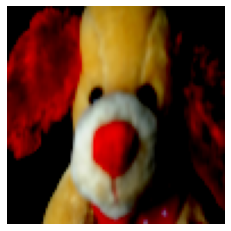

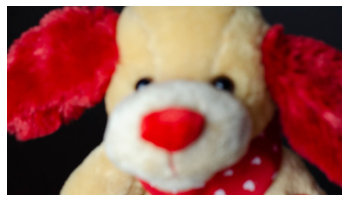

In [70]:
### TEST THE MODEL WITH A NEW IMAGE ####

## load the image 
IMAGE_PATH = PATH + 'floue_test.jpg'
image_test = Image.open(IMAGE_PATH)

#convert to numpy array
image = np.array(image_test)

plt.imshow(image)
plt.axis('off')

##normalize the image 
image_test_norm = (image - 127.5)/127.5 

##resize 
shape_test = x_test_lr[0].shape
image_test_process = resize(image_test_norm, shape_test, mode='reflect', anti_aliasing=True)
plt.imshow(image_test_process)
plt.axis('off')

## renormalize the image
image_test_process = (image_test_process - 127.5) / 127.5
#print(image_test_process.shape)

# Add batch dimension
image_batch_lr = np.expand_dims(image_test_process, axis=0)

generator_path = PATH + 'gen_model10.h5'
# Load the saved generator model
generator = load_model(generator_path, custom_objects={'loss_function': vgg_loss_wrapper(image_shape)})

gen_img = generator.predict(image_batch_lr)
#generated_image = denormalize(gen_img)
#print(gen_img[0])
#print(generated_image)
    
plt.figure()
plt.imshow(gen_img[0], interpolation='nearest')
plt.imshow(image_test)
plt.axis('off')
        
#plt.tight_layout()
#plt.savefig(output_dir + 'high_res_result_image_%d.png' % index)
#plt.show()